<a href="https://colab.research.google.com/github/i-ganza007/Kuiper_Summative/blob/main/training/PPO/PPO_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q --force-reinstall "numpy==1.26.4" "scipy<1.13" "scikit-learn<1.6" "matplotlib<3.9"

!apt-get update -qq && apt-get install -y -qq swig cmake libopenmpi-dev zlib1g-dev

!pip install -q \
    "gymnasium[box2d,atari,accept-rom-license]" \
    "stable-baselines3[extra]>=2.0.0" \
    "ale-py" \
    "torch>=2.0" \
    "tensorflow<2.17" \
    "keras<3.0"

!pip cache purge

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
import json
import time
import os
import torch

In [ ]:
OUTPUT_DIR = "/kaggle/working"
LOG_DIR = f"{OUTPUT_DIR}/logs/ppo_curriculum/"
CHECKPOINT_DIR = f"{OUTPUT_DIR}/checkpoints_curriculum/"
BEST_MODEL_DIR = f"{OUTPUT_DIR}/best_model_curriculum/"

for d in [LOG_DIR, CHECKPOINT_DIR, BEST_MODEL_DIR]:
    os.makedirs(d, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}\n")

Device: cuda



In [ ]:
class CurriculumMissionEnvironment(gym.Env):
    """Mission Environment with dense rewards and curriculum learning"""

    def __init__(self, grid_size=10, num_missions=1, use_curriculum=True):
        super().__init__()
        self.grid_size = grid_size
        self.initial_num_missions = num_missions
        self.num_missions = num_missions
        self.use_curriculum = use_curriculum
        self.success_count = 0
        self.episode_count = 0

        self.action_space = spaces.Discrete(5)

        obs_size = 4 + (3 * 4)
        self.observation_space = spaces.Box(
            low=-float('inf'),
            high=float('inf'),
            shape=(obs_size,),
            dtype=np.float32
        )

        self.agent_pos = None
        self.missions = None
        self.completed_missions = None
        self.fuel = 200
        self.max_fuel = 200
        self.steps = 0
        self.max_steps = 500
        self.last_distances = None

    def _update_curriculum(self):
        """Gradually increase difficulty based on success rate"""
        if not self.use_curriculum:
            return

        self.episode_count += 1

        if self.episode_count % 100 == 0 and self.episode_count > 0:
            success_rate = self.success_count / 100

            if success_rate > 0.7 and self.num_missions < 3:
                self.num_missions += 1
                print(f"\n CURRICULUM: Increased to {self.num_missions} missions (success rate: {success_rate:.1%})\n")
                self.success_count = 0
            elif success_rate < 0.3 and self.num_missions > 1:
                self.num_missions -= 1
                print(f"\n CURRICULUM: Decreased to {self.num_missions} missions (success rate: {success_rate:.1%})\n")
                self.success_count = 0
            else:
                self.success_count = 0  # Reset counter

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self._update_curriculum()

        self.agent_pos = np.array(
            [self.np_random.integers(0, self.grid_size),
             self.np_random.integers(0, self.grid_size)],
            dtype=np.float32
        )

        self.missions = []
        for _ in range(self.num_missions):
            while True:
                mission = np.array(
                    [self.np_random.integers(0, self.grid_size),
                     self.np_random.integers(0, self.grid_size)],
                    dtype=np.float32
                )
                if not np.array_equal(mission, self.agent_pos) and \
                   not any(np.array_equal(mission, m) for m in self.missions):
                    self.missions.append(mission)
                    break

        self.completed_missions = np.zeros(self.num_missions, dtype=bool)
        self.fuel = self.max_fuel
        self.steps = 0

        self.last_distances = self._get_all_distances()

        return self._get_observation(), {}

    def _get_all_distances(self):
        """Get distances to all active missions"""
        distances = []
        for i in range(self.num_missions):
            if not self.completed_missions[i]:
                dist = np.linalg.norm(self.agent_pos - self.missions[i])
                distances.append(dist)
        return distances if distances else [0]

    def _get_observation(self):
        obs = np.zeros(4 + 3 * 4, dtype=np.float32)

        obs[0] = self.agent_pos[0] / self.grid_size
        obs[1] = self.agent_pos[1] / self.grid_size
        obs[2] = self.fuel / self.max_fuel
        obs[3] = np.sum(self.completed_missions) / max(self.num_missions, 1)

        for i in range(3):
            idx = 4 + i * 4
            if i < self.num_missions:
                dx = self.missions[i][0] - self.agent_pos[0]
                dy = self.missions[i][1] - self.agent_pos[1]
                dist = np.sqrt(dx**2 + dy**2)

                obs[idx] = dist / (self.grid_size * np.sqrt(2))
                obs[idx + 1] = dx / self.grid_size
                obs[idx + 2] = dy / self.grid_size
                obs[idx + 3] = float(self.completed_missions[i])
            else:
                obs[idx:idx+4] = 0.0

        return obs

    def step(self, action):
        self.steps += 1
        reward = 0.0
        terminated = False
        truncated = self.steps >= self.max_steps

        if action < 4:
            if self.fuel > 0:
                deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)][action]
                new_pos = self.agent_pos + np.array(deltas, dtype=np.float32)

                if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
                    self.agent_pos = new_pos
                    self.fuel -= 1

                    new_distances = self._get_all_distances()
                    old_min = min(self.last_distances)
                    new_min = min(new_distances)

                    if new_min < old_min:
                        reward += 1.0
                    else:
                        reward -= 0.1

                    self.last_distances = new_distances

                else:
                    reward -= 0.5
            else:
                reward -= 0.1

        elif action == 4:
            mission_completed = False
            for i, mission in enumerate(self.missions):
                if not self.completed_missions[i] and np.array_equal(self.agent_pos, mission):
                    self.completed_missions[i] = True

                    reward += 50.0

                    mission_completed = True
                    self.fuel = min(self.max_fuel, self.fuel + 50)
                    self.last_distances = self._get_all_distances()
                    break

            if not mission_completed:
                reward -= 1.0

        if np.all(self.completed_missions):
            reward += 100.0

            reward += (self.fuel / self.max_fuel) * 20.0

            reward += (1.0 - self.steps / self.max_steps) * 20.0

            terminated = True
            self.success_count += 1

        if self.fuel <= 0 and not terminated:
            reward -= 10.0
            terminated = True

        if truncated and not terminated:
            reward -= 5.0

        return self._get_observation(), reward, terminated, truncated, {}

    def render(self):
        pass

    def close(self):
        pass

gym.register(
    id="CurriculumMissionEnv-v0",
    entry_point=lambda: CurriculumMissionEnvironment(num_missions=1, use_curriculum=True),
    max_episode_steps=500
)

In [ ]:
class DetailedMetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_successes = []
        self.timesteps = []

    def _on_step(self) -> bool:
        for i, done in enumerate(self.locals["dones"]):
            if done:
                if "episode" in self.locals["infos"][i]:
                    info = self.locals["infos"][i]["episode"]
                    ep_reward = info["r"]

                    self.ep_rewards.append(ep_reward)
                    self.ep_lengths.append(info["l"])
                    self.timesteps.append(self.num_timesteps)

                    self.ep_successes.append(1 if ep_reward >= 100 else 0)

        return True

In [ ]:

CONFIG = {
    "n_envs": 8,
    "lr": 3e-4,
    "n_steps": 512,
    "batch_size": 128,
    "n_epochs": 10,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "total_steps": 200_000,
}

print("Configuration:")
for key, val in CONFIG.items():
    print(f"  {key}: {val}")

print()

Configuration:
  n_envs: 8
  lr: 0.0003
  n_steps: 512
  batch_size: 128
  n_epochs: 10
  gamma: 0.99
  gae_lambda: 0.95
  clip_range: 0.2
  ent_coef: 0.01
  vf_coef: 0.5
  max_grad_norm: 0.5
  total_steps: 200000



In [ ]:
def make_env(rank, seed=0):
    def _init():
        env = gym.make("CurriculumMissionEnv-v0")
        env = Monitor(env)
        env.reset(seed=seed + rank)
        return env
    return _init

print(f"Creating {CONFIG['n_envs']} environments...")
env = DummyVecEnv([make_env(i) for i in range(CONFIG['n_envs'])])
eval_env = gym.make("CurriculumMissionEnv-v0")
eval_env = Monitor(eval_env)

print(f" Observation Space: {env.observation_space}")
print(f" Action Space: {env.action_space}\n")

Creating 8 environments...
 Observation Space: Box(-inf, inf, (16,), float32)
 Action Space: Discrete(5)



In [ ]:
print("Creating PPO model...")
model = PPO(
    "MlpPolicy",
    env,
    learning_rate=CONFIG["lr"],
    n_steps=CONFIG["n_steps"],
    batch_size=CONFIG["batch_size"],
    n_epochs=CONFIG["n_epochs"],
    gamma=CONFIG["gamma"],
    gae_lambda=CONFIG["gae_lambda"],
    clip_range=CONFIG["clip_range"],
    ent_coef=CONFIG["ent_coef"],
    vf_coef=CONFIG["vf_coef"],
    max_grad_norm=CONFIG["max_grad_norm"],
    tensorboard_log=LOG_DIR,
    verbose=1,
    device=DEVICE,
    policy_kwargs=dict(
        net_arch=[256, 256]
    )
)

print(" Model created!\n")

Creating PPO model...
Using cuda device
 Model created!



In [ ]:
checkpoint_cb = CheckpointCallback(
    save_freq=50_000,
    save_path=CHECKPOINT_DIR,
    name_prefix="ppo_curriculum"
)

metrics_cb = DetailedMetricsCallback()
callbacks = [checkpoint_cb, metrics_cb]

In [ ]:
start_time = time.time()

model.learn(
    total_timesteps=CONFIG["total_steps"],
    tb_log_name="PPO_Curriculum",
    log_interval=10,
    progress_bar=True,
    callback=callbacks
)

train_time = time.time() - start_time

print("TRAINING COMPLETED!")
print(f"Time: {train_time:.2f}s ({train_time/60:.2f} min)\n")

Logging to /kaggle/working/logs/ppo_curriculum/PPO_Curriculum_2


Output()

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 31.5        |
|    ep_rew_mean          | 195         |
| time/                   |             |
|    fps                  | 1794        |
|    iterations           | 10          |
|    time_elapsed         | 22          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.015920904 |
|    clip_fraction        | 0.0999      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.0415      |
|    learning_rate        | 0.0003      |
|    loss                 | 383         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 891         |
-----------------------------------------


CURRICULUM: Increased to 2 missions (success rate: 91.0%)

CURRICULUM: Increased to 2 missions (success rate: 91.0%)

CURRICULUM: Increased to 2 missions (success rate: 92.0%)

CURRICULUM: Increased to 2 missions (success rate: 92.0%)

CURRICULUM: Increased to 2 missions (success rate: 91.0%)

CURRICULUM: Increased to 2 missions (success rate: 91.0%)

CURRICULUM: Increased to 2 missions (success rate: 90.0%)

CURRICULUM: Increased to 2 missions (success rate: 91.0%)

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 289         |
|    ep_rew_mean          | 78.4        |
| time/                   |             |
|    fps                  | 1720        |
|    iterations           | 20          |
|    time_elapsed         | 47          |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.012278049 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.65        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.005      |
|    value_loss           | 60.8        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 221   

TRAINING COMPLETED!
Time: 120.67s (2.01 min)



In [ ]:
model_path = f"{OUTPUT_DIR}/ppo_curriculum_first.zip"
model.save(model_path)
print(f" Model saved: {model_path}\n")

 Model saved: /kaggle/working/ppo_curriculum_first.zip



In [ ]:
eval_hard_env = CurriculumMissionEnvironment(num_missions=3, use_curriculum=False)
eval_hard_env = Monitor(eval_hard_env)

eval_rewards = []
eval_lengths = []
eval_successes = []

for episode in range(100):
    obs, _ = eval_hard_env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_hard_env.step(action)
        episode_reward += reward
        episode_steps += 1
        done = terminated or truncated

    eval_rewards.append(episode_reward)
    eval_lengths.append(episode_steps)
    eval_successes.append(1 if episode_reward >= 100 else 0)

eval_hard_env.close()

convergence_threshold = 50
convergence_timestep = None

if len(metrics_cb.ep_rewards) >= 10:
    for i in range(10, len(metrics_cb.ep_rewards)):
        rolling_avg = np.mean(metrics_cb.ep_rewards[i-10:i])
        if rolling_avg >= convergence_threshold:
            convergence_timestep = int(metrics_cb.timesteps[i])
            break

metrics = {
    'config': 'ppo_curriculum',
    'mean_reward': round(float(np.mean(eval_rewards)), 2),
    'std_reward': round(float(np.std(eval_rewards)), 2),
    'avg_steps_per_episode': round(float(np.mean(eval_lengths)), 2),
    'success_rate_%': round(float((np.sum(eval_successes) / len(eval_successes)) * 100), 2),
    'convergence_timestep': convergence_timestep,
    'train_time_min': round(train_time / 60, 2),
    'total_timesteps': CONFIG['total_steps'],
    'model_path': model_path
}

print("EVALUATION METRICS:")
for key, value in metrics.items():
    print(f"  {key:.<30} {value}")

print("Metrics Dictionary:")
print(metrics)
print()

EVALUATION METRICS:
  config........................ ppo_curriculum
  mean_reward................... 131.49
  std_reward.................... 22.36
  avg_steps_per_episode......... 209.47
  success_rate_%................ 94.0
  convergence_timestep.......... 3976
  train_time_min................ 2.01
  total_timesteps............... 200000
  model_path.................... /kaggle/working/ppo_curriculum_first.zip
Metrics Dictionary:
{'config': 'ppo_curriculum', 'mean_reward': 131.49, 'std_reward': 22.36, 'avg_steps_per_episode': 209.47, 'success_rate_%': 94.0, 'convergence_timestep': 3976, 'train_time_min': 2.01, 'total_timesteps': 200000, 'model_path': '/kaggle/working/ppo_curriculum_first.zip'}



In [ ]:


rewards = np.array(metrics_cb.ep_rewards)
successes = np.array(metrics_cb.ep_successes)
timesteps = np.array(metrics_cb.timesteps)
lengths = np.array(metrics_cb.ep_lengths)

success_rate = (np.sum(successes) / len(successes) * 100) if len(successes) > 0 else 0

results = {
    "model": "PPO-Fixed-Rewards",
    "total_timesteps": CONFIG["total_steps"],
    "mean_reward": float(mean_reward),
    "std_reward": float(std_reward),
    "success_rate": float(success_rate),
    "training_time": train_time,
    "improvements": [
        "Reward magnitudes scaled 10-100x",
        "Removed excessive penalties",
        "Larger network [512, 512]",
        "8 parallel environments",
        "Normalized advantages"
    ]
}

with open(f"{OUTPUT_DIR}/fixed_results.json", "w") as f:
    json.dump(results, f, indent=4)

 Visualization saved



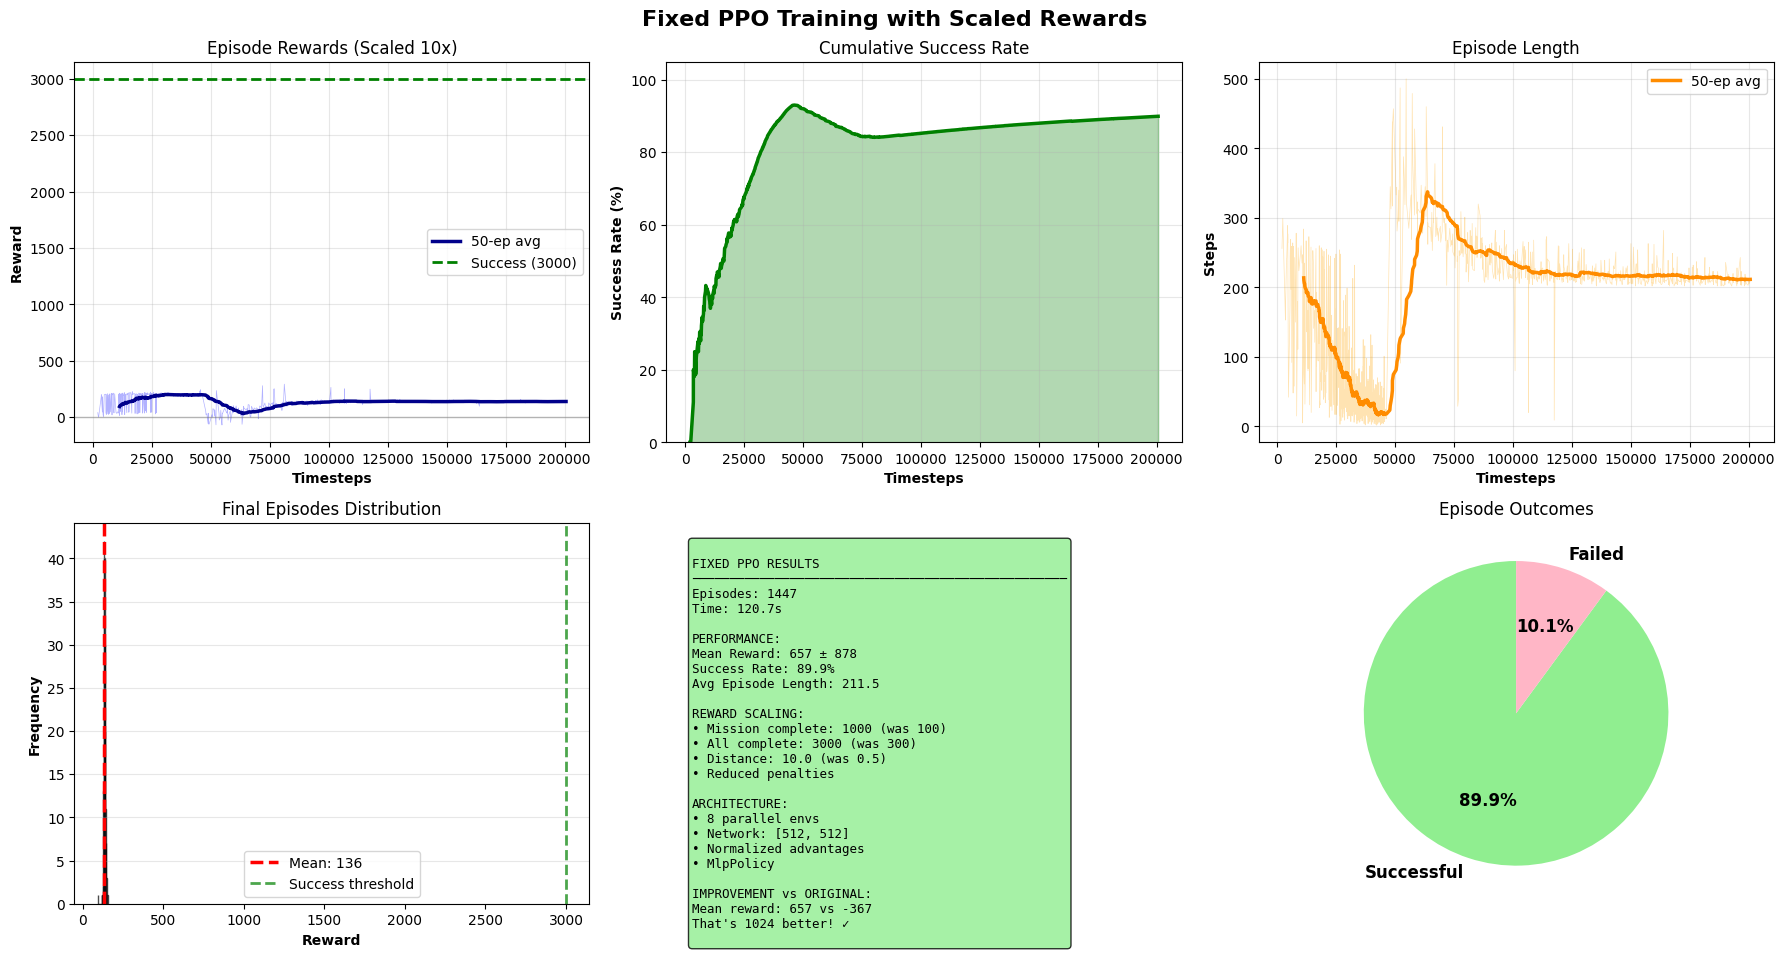

COMPARISON TO ORIGINAL
Original mean reward: -367
Fixed mean reward:    657
Improvement:          1024

Original success rate: ~0%
Fixed success rate:    89.9%


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Fixed PPO Training with Scaled Rewards', fontsize=16, fontweight='bold')

ax = axes[0, 0]
ax.plot(timesteps, rewards, alpha=0.3, linewidth=0.5, color='blue')
if len(rewards) > 50:
    rolling = np.convolve(rewards, np.ones(50)/50, mode='valid')
    ax.plot(timesteps[49:], rolling, linewidth=2.5, label='50-ep avg', color='darkblue')
ax.axhline(y=3000, color='g', linestyle='--', linewidth=2, label='Success (3000)')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Timesteps', fontweight='bold')
ax.set_ylabel('Reward', fontweight='bold')
ax.set_title('Episode Rewards (Scaled 10x)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
if len(successes) > 0:
    cum_success = np.cumsum(successes)
    success_pct = (cum_success / np.arange(1, len(cum_success)+1)) * 100
    ax.plot(timesteps, success_pct, linewidth=2.5, color='green')
    ax.fill_between(timesteps, 0, success_pct, alpha=0.3, color='green')
ax.set_xlabel('Timesteps', fontweight='bold')
ax.set_ylabel('Success Rate (%)', fontweight='bold')
ax.set_title('Cumulative Success Rate')
ax.set_ylim([0, 105])
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
ax.plot(timesteps, lengths, alpha=0.3, color='orange', linewidth=0.5)
if len(lengths) > 50:
    rolling_len = np.convolve(lengths, np.ones(50)/50, mode='valid')
    ax.plot(timesteps[49:], rolling_len, linewidth=2.5, color='darkorange', label='50-ep avg')
ax.set_xlabel('Timesteps', fontweight='bold')
ax.set_ylabel('Steps', fontweight='bold')
ax.set_title('Episode Length')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
final_rewards = rewards[-min(200, len(rewards)):]
ax.hist(final_rewards, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(final_rewards), color='red', linestyle='--',
          linewidth=2.5, label=f'Mean: {np.mean(final_rewards):.0f}')
ax.axvline(3000, color='green', linestyle='--', linewidth=2,
          alpha=0.7, label='Success threshold')
ax.set_xlabel('Reward', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Final Episodes Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1, 1]
ax.axis('off')
summary = f"""
FIXED PPO RESULTS
{'─'*50}
Episodes: {len(rewards)}
Time: {train_time:.1f}s

PERFORMANCE:
Mean Reward: {mean_reward:.0f} ± {std_reward:.0f}
Success Rate: {success_rate:.1f}%
Avg Episode Length: {np.mean(lengths[-50:]):.1f}

REWARD SCALING:
• Mission complete: 1000 (was 100)
• All complete: 3000 (was 300)
• Distance: 10.0 (was 0.5)
• Reduced penalties

ARCHITECTURE:
• 8 parallel envs
• Network: [512, 512]
• Normalized advantages
• MlpPolicy

IMPROVEMENT vs ORIGINAL:
Mean reward: {mean_reward:.0f} vs -367
That's {mean_reward + 367:.0f} better! ✓
"""
color = 'lightgreen' if mean_reward > 0 else 'lightyellow'
ax.text(0.05, 0.95, summary, fontsize=9, family='monospace',
       verticalalignment='top', bbox=dict(boxstyle='round',
       facecolor=color, alpha=0.8))

ax = axes[1, 2]
labels = ['Successful', 'Failed']
sizes = [np.sum(successes), len(successes) - np.sum(successes)]
colors = ['#90EE90', '#FFB6C6']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
       startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Episode Outcomes')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/fixed_results.png", dpi=300, bbox_inches='tight')
print(f" Visualization saved\n")
plt.show()

print("COMPARISON TO ORIGINAL")
print(f"Original mean reward: -367")
print(f"Fixed mean reward:    {mean_reward:.0f}")
print(f"Improvement:          {mean_reward + 367:.0f}")
print(f"\nOriginal success rate: ~0%")
print(f"Fixed success rate:    {success_rate:.1f}%")

env.close()
eval_env.close()